100%|██████████| 100000/100000 [00:04<00:00, 22001.88it/s]


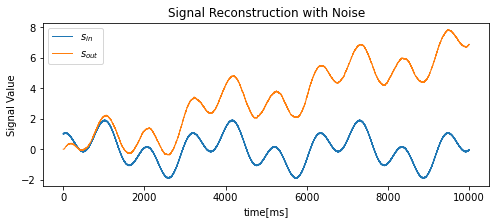

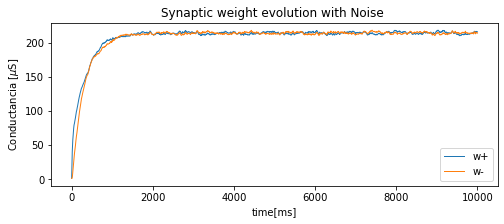

In [4]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt

#variables temporales
dt = 0.1
t_ini = 0
t_fin = 10000
tiempo = np.arange(t_ini, t_fin, dt)


class RSTDP:
    Ap = 1
    Am = -Ap
    tE = 10
    wmin = 1            #peso sinaptico minimo 1mS (Conductancia)
    wmax = 1000         #peso sinaptico max 1000mS (Conductancia)
    def __init__(self):
        self.w = 1        
        self.E = 0             
        self.dE = 0
        self.w_hist = []
    
    def update(self, dd_prev, dd_post, R):
        Ap = self.Ap
        Am = self.Am
        tE = self.tE

        w = self.w
        E = self.E

        Wpre =  Ap * dd_prev 
        Wpost = Am * dd_post
        dE = (-E/tE) + Wpre + Wpost
        E = E + dt * dE
        dw = R * E
        w = w + dt * dw

        if(w<self.wmin):
            w = 1
        elif(w>self.wmax):
            w = self.wmax

        self.E = E
        self.w = w
        self.w_hist.append(w)

class StepFowardEncoder:
    def __init__(self, thr):
        self.base = 0
        self.thr = thr
    
    def encode(self, x):
        OutP = 0
        OutN = 0
        base = self.base
        thr = self.thr
        if(x > (base + thr)):
            OutP = 1
            base = base + thr
        elif(x < (base - thr)):
            OutN = 1
            base = base - thr
        self.base = base
        return [OutP, OutN]

class StepFowardDecoder:
    def __init__(self, thr):
        self.base = 0
        self.thr = thr

    def decode(self, spk_pos, spk_neg):
        thr = self.thr
        base = self.base
        if(spk_pos == 1):
            base = self.base +  thr
        elif(spk_neg == 1):
            base = self.base - thr
        self.base = base
        return base

class LIF:
    #Modelo LIF 
    Rm = 10              #Resistencia de membrana 10MOhms (10e6)
    Cm = 1               #Capacitancia de membrana 1nF (1e-9)
    tm = Rm * Cm         #constante temporal membrana  [ms]
    El = -70             #voltaje de reposo  mV
    vreset = -75         #voltaje de reset   mV
    vth = -55            #voltaje de  umbral mV
    vspike = 20          #voltaje de disparo m
    T = 50
    def __init__(self):
        self.V = self.El
        self.tf = []
        self.frec_hist = []
        self.Isyn_hist = []

    def sim_neuron(p, t, Isyn):
        V = p.V
        dV = (p.El - V + p.Rm * Isyn)/p.tm
        V = V + dt * dV
        diracDelta = 0
        if(V >= p.vth):
            V = p.vreset               #se resetea el voltaje de membrana
            diracDelta = 1             #lo mismo que diracDelta con t=tf
            p.tf.append(t)           #agregando el nuevo tiempo de disparo
        
        #calculando la frecuencia
        p.checkFiringTimes(t)
        f = (len(p.tf)) * (1000/p.T)

        p.frec_hist.append(f)
        p.Isyn_hist.append(Isyn)
        p.V = V
        return diracDelta
    
    def checkFiringTimes(self, t):
        #metodo que solo guarda los tiempos de disparo de neurona que estan dentro del lapso T
        tf = np.array(self.tf)
        new_tf = tf[(t - tf) < self.T]
        self.tf = new_tf.tolist()
        

class LIFspk(LIF):
    #Modelo LIF aumentado que calcula la corriente de entrada en funcion de los disparos
    def __init__(self):
        self.V = self.El
        self.Isyn = 0
        self.tf = []
        self.frec_hist = []

    def sim_neuron(p, t, w_dd):
        Isyn = p.Isyn
        V = p.V

        dIsyn = (-Isyn + p.Cm * w_dd)/p.tm
        dV = (p.El - V + p.Rm * Isyn)/p.tm
        Isyn = Isyn + dt * dIsyn
        V = V + dt * dV

        diracDelta = 0
        if(V >= p.vth):
            V = p.vreset               #se resetea el voltaje de membrana
            diracDelta = 1                 #lo mismo que diracDelta con t=tf
            p.tf.append(t)           #agregando el nuevo tiempo de disparo
        
        #calculando la frecuencia
        p.checkFiringTimes(t)
        f = (len(p.tf)) * (1000/p.T)
        p.frec_hist.append(f)

        p.Isyn = Isyn
        p.V = V
        return diracDelta



syn_p1 = RSTDP()
syn_n1 = RSTDP()

np1 = LIFspk()
nn1 = LIFspk()


th_q = 0.02 
encoder = StepFowardEncoder(th_q)
decoder = StepFowardDecoder(th_q)

w = 0.002
input_signal = np.sin(w*tiempo) + np.cos(3*w*tiempo)

noise = np.random.normal(0, 0.01, input_signal.shape)
input_signal = input_signal + noise
output_signal = []

teqdm = range(len(tiempo))        
for a in tqdm(teqdm):
    t = tiempo[a]
    
    [spk_plus, spk_neg] = encoder.encode(input_signal[a])

    tfp1 = np1.sim_neuron(t, spk_plus * syn_p1.w )
    tfn1 = nn1.sim_neuron(t, spk_neg * syn_n1.w )

    syn_p1.update(spk_plus, tfp1, 1)
    syn_n1.update(spk_neg, tfn1, 1)

    output_signal.append(decoder.decode(tfp1, tfn1))
    
    
# fig2, (ax2) = plt.subplots(1, figsize=(8,3))
# ax2.plot(tiempo,input_signal,linewidth = 1, label = '$s_{in}$')
# ax2.plot(tiempo,output_signal,linewidth = 1, label = '$s_{out}$')
# ax2.legend()
# ax2.set(xlabel = 'time[ms]' , ylabel = 'Signal Value')
# ax2.set_title('Signal Reconstruction ')
# fig2.savefig('Reconstruction.pdf')


# fig2, (ax2) = plt.subplots(1, figsize=(8,3))
# ax2.plot(tiempo,syn_p1.w_hist,linewidth = 1, label = 'w+')
# ax2.plot(tiempo,syn_n1.w_hist,linewidth = 1, label = 'w-')
# ax2.legend()
# ax2.set(xlabel = 'time[ms]' , ylabel = 'Conductancia [$\mu$S]')
# ax2.set_title('Synaptic weight evolution ')
# fig2.savefig('synnapses.pdf') 

fig2, (ax2) = plt.subplots(1, figsize=(8,3))
ax2.plot(tiempo,input_signal,linewidth = 1, label = '$s_{in}$')
ax2.plot(tiempo,output_signal,linewidth = 1, label = '$s_{out}$')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'Signal Value')
ax2.set_title('Signal Reconstruction with Noise')
fig2.savefig('ReconstructionNoise.pdf')


fig2, (ax2) = plt.subplots(1, figsize=(8,3))
ax2.plot(tiempo,syn_p1.w_hist,linewidth = 1, label = 'w+')
ax2.plot(tiempo,syn_n1.w_hist,linewidth = 1, label = 'w-')
ax2.legend()
ax2.set(xlabel = 'time[ms]' , ylabel = 'Conductancia [$\mu$S]')
ax2.set_title('Synaptic weight evolution with Noise ')
fig2.savefig('synnapsesNoise.pdf') 

